# Часть 2: Deep Learning

Для начала напомним основные понятия машинного обучения.

Что такое моделирование? Это когда мы пытаемся как-то задать зависимость (функцию) между фичами ($X$) и целевой переменной ($y$).

* Для этого мы пользуемся какими-то предположениями о том, как должно выглядеть идеальное решение. Например, мы можем сказать «$y = f_k(x) = kx + \epsilon$ для какого-то $k$», то есть мы можем предположить, что переменные $x$ и $y$ связаны как-то линейно, но коэффициент пропорциональности мы не знаем, и тогда он будет называться **параметром** модели.
* После этого мы вводим какую-то **функцию потерь** (например, $l(y') = (y'-y)^2$) и подбираем параметры модели, которые минимизируют её ожидаемое значение.

Как подбирать эти параметры? В простых случаях, вроде линейной регрессии, они находятся аналитически: нужно взять производную, приравнять к нулю и решить систему уравнений. Но иногда эти функции намного сложнее. Как их оптимизировать?

## Добро пожаловать в мир дифференцируемых функций

Автор определяет следующую «иерархию хороших функций», с точки зрения лёгкости нахождения минимума:

* Аналитически решаемые — их глобальный минимум можно выразить какой-то простой формулой. Пример: линейная регрессия.
* Выпуклые. У них гарантируется решение, причём единственное, и оно быстро ищется разными методами, в частности градиентным спуском (но обычно можно даже быстрее). Пример: логистическая регрессия.
* Дифференцируемые. К ним можно применить градиентный спуск, и, возможно, он сойдётся не к локальному минимуму, а к глобальному. **<-- YOU ARE HERE**
* Дискретные. Тут обычно всё грустно, но нам хотя бы можно быстро узнать её значение.
* Невычислимые. Иногда нам нужно оценивать что-нибудь совсем не формализуемое математикой — например, качество перевода, или поведение пользователя. Невычислимыми функциями, в частности, занимается Reinforcement Learning.

В курсе вы будете заниматься разными способами задания моделей, состоящих только из *дифференцируемых* относительно параметров преобразований, что позволит искать (иногда успешно, иногда нет) набор параметров, при которых ожидание функции потерь имеет минимальное значение.

## Градиентный спуск

**Градиентом** называют вектор (набор чисел), каждой компонентой которого является значение производной по очередному аргументу (при фиксированных остальных).

**Ок, зачем он нужен?** Пусть у нас есть какая-нибудь функция, которую мы хотим минимизировать, и мы предполагаем, что она выглядит как что-то типа гладкой ямы. Тогда мы можем попытаться действовать так: начнем с какой-нибудь точки и будем делать много очень маленьких шажков в сторону наибольшего уменьшения функции, пока не придем в локальный минимум.

* Что значит «в сторону наибольшего уменьшения»? Это значит «против градиаента».
* Что такое «маленький шажок»? Это значит $-\lambda \cdot (f'_1, f'_2, \ldots, f'_n)$. Обычно $\lambda$ это что-то типа $10^{-3}$. Этот параметр называется learning rate (скорость обучения).
* Что значит «пока не придём в локальный минимум». Это значит «пока градиент не ноль». На практике будем проверять, что норма (т. е. длина вектора) больше определенного очень малого $\epsilon$.

Если learning rate достоаточно маленький, мы точно придем хотя бы в локальный минимум. Этот метод называется **градиентным спуском**, и он очень часто применяется для оптимизации тех функций, у которых везде можно быстро посчитать градиент. Гарантированно находить глобальный минимум произвольной функции наука пока не умеет (и вряд ли когда-либо научится).

### Эвристики

В сложных моделях — например, нейросетях — поверхности оптимизируемых функций обычно выглядят весьма страшно:

<img width='250px' src='https://ml4a.github.io/images/figures/non_convex_function.png'>

«Плохих» точек в процессе оптимизации на самом деле существует два типа: где градиент нулевой и где градиент бесконечный.

**Моментум**. Что делать, если мы попали в какую-то точку, где градиента практически нет? Будем шагать каждый раз не в сторону градиента в данной точке, а в сторону *экспоненциально усреднённого* градиента по всем предыдущим итерациям (градиенты с последних итераций будут иметь больший вес). Для этого вводится специальный гиперпараметр $0 < \gamma < 1$, а рядом с каждым параметром хранится усреднённое среднее его градиентов, которое обновляется по следующей формуле:

$$ \hat{g}_i = \hat{g}_{i-1} \cdot \gamma + g_i $$

<img width='250px' src='https://upload.wikimedia.org/wikipedia/commons/thumb/1/1e/Saddle_point.svg/300px-Saddle_point.svg.png'>

**RMSProp**. Что делать, если мы на «обрыве»? Будем поддерживать таким же образом усреднённые *квадраты* градиентов, и при обновлении параметров нормировать градиент, деля его на корень из этой оценки. Так оптимизатор будет адаптироваться под «турбулентные» регионы, уменьшая в них размер шага и не давая параметрам улететь куда-то далего из-за обрывов.

<img width='250px' src='https://3.bp.blogspot.com/-fJQ8OM1dHl4/WV363VZZVqI/AAAAAAAAFSk/0e0EuS3WZ9gv5jW93cuF-XjU2FAN42VMQCLcBGAs/s1600/gradient_clipping.png'>

Алгоритм, объединяющий эти две эвристики, называется **Adam**. Он является одним из самых часто используемых оптимизаторов в глубоком обучении.

Подробнее прочитать про эвристики в градиентном спуске можно тут: http://ruder.io/optimizing-gradient-descent/

### Стохастический градиентный спуск

Нам может потребоваться много итераций, чтобы градиентный спуск сошелся. Более того, время выполнения одной итерации может быть очень большим хотя бы потому, что нам нужно каждый раз просмотреть весь датасет. Поэтому для каждого шага градиентного спуска будем использовать не точный градиент, а его оценку: выберем несколько десятков примеров — такой набор называется батчем (англ. batch — пакет, группа) — посчитаем на них градиенты и усредним. Получаем шумную, но приемлимую для нас оценку градиента. Такой вид градиентного спуска называют стохастическим (SGD — stochastic gradient descent).

Почему бы не брать вообще один пример? На самом деле, с точки зрения теории — можно. Но на практике оптимальный размер батча совсем маленьким делать не стоит из-за параллелизма: на устройстах, на которых эти градиенты считаются, затратится меньше времени на пример, если данные обрабатывать не поштучно, а группами (включите GPU в Google Colab и выполните ячейки снизу).

[Можно показать](https://openreview.net/pdf?id=B1Yy1BxCZ), что чтобы скомпенсировать уменьшение размера батча, нужно во столько же раз уменьшить learning rate. Иными словами, более шумные оценки градиента можно компенсировать более мелкими и аккуратными шагами.

<img width='500px' src='https://sqream.com/wp-content/uploads/2017/03/cpu_vs_gpu-11.png'>

Если вы работаете локально, то зайдите на https://pytorch.org/get-started/locally/ и установите PyTorch.

In [42]:
import torch
import numpy

In [43]:
A = numpy.random.randn(1000, 5000)
B = numpy.random.randn(5000, 2000)

%time C = numpy.matmul(A, B)

Wall time: 603 ms


In [72]:
A = torch.randn(1000, 5000)
B = torch.randn(5000, 2000)

%time C = torch.matmul(A, B)

Wall time: 456 ms


In [ ]:
# если вы открыли тетрадку через Google Colab, то включите GPU
# (сверху слева Runtime -> Change runtime type... -> GPU)

A = torch.randn(1000, 5000).cuda()
B = torch.randn(5000, 2000).cuda()

%time C = torch.matmul(A, B)

----

## Практическая часть: фреймворки

Чтобы оптимизировать функцию потерь относительно параметров градиентным спуском, нужно для начала этот градиент хотя бы посчитать. Как вы убедитесь на 3-м занятии, это больно делать вручную. Для этого существуют фреймворки, которые сами посчитают производные за нас. Помимо своей основной функции (поддержка эффективного автоматического дифференцирования и оптимизаторов), они также включают полезные абстракции для машинного обучения.

Фреймворков много, и становится ещё больше. Мы будем использовать **PyTorch**. Вам он будет очень напоминать numpy — по сути он может делать всё то же, только ещё и считать градиенты относительно параметров.

PyTorch можно использовать как замену numpy:

In [74]:
x = torch.tensor([1., 2., 3.])
y = torch.tensor([4., 5., 6.])
z = x + y

print(z)

tensor([5., 7., 9.])


In [75]:
# при создании переменных можно поставить флаг requires_grad
x = torch.tensor([1., 2., 3], requires_grad=True)

# с этим флагом мы можем делать те же операции, что и раньше
y = torch.tensor([4., 5., 6], requires_grad=True)
z = torch.dot(x, y)
print(z)

tensor(32., grad_fn=<DotBackward>)


...но теперь z кое-что знает о себе:

In [76]:
print(z.grad_fn)

`z` — скаляр, и мы можем продиффиренцировать весь граф относительно него:

In [77]:
z.backward()

И теперь рядом со всеми переменными с requires_grad=True, которые как-либо использовались при получении z, теперь будут их градиенты.

In [42]:
print(x.grad)
print(y.grad)

tensor([4., 5., 6.])
tensor([1., 2., 3.])


Мы сможем потом использовать эти градиенты, чтобы оптимально подвинуть параметры в градиентном спуске.

## MNIST

Это всё было абстрактно. Рассмотрим более конкретный пример.

Датасет MNIST включает в себя 70000 черно-белых изображений цифр от 0 до 9, каждое 28 на 28 пиксилей. Задача — предсказать по изображению наиболее вероятную цифру, соответствующую изображению.

<img width='400px' src='https://camo.githubusercontent.com/24545a9ca1aa3b5d1036bd3deaed3ed7ec6cfdc4/68747470733a2f2f692e696d6775722e636f6d2f4954726d3978342e706e67'>

**Нейронная сеть** — это просто какая-то последовательность дифференцируемых операций со входными данными. Обычно эти массовые операции над векторами называют **слоями**. Самый простой пример — матричное умножение, за которым следует операция `softmax`:

$$ \sigma(x)_k = \frac{e^{x_k}}{\sum_i e^{x_i}} $$

Она возвращает вероятностное распределение: нетрудно убедиться, что каждый элемент неотрицателен, и все $\sigma_i$ суммируются в единицу. Если кто помнит, мы только что описали логистическую регрессию, которая тоже в каком-то смысле является очень простой нейросетью.

Обучим какую-нибудь нейросеть, которая принимает вектора размера $784 = 28^2$ и возвращает вероятностное распределение. 

**ВАЖНО**: из-за вычислительных причин мы почти всегда будем обрабатывать данные по батчам, и поэтому размерности входных и промежуточных данных всегда будут вида (batch_size x dim).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_loader(train, batch_size):
    '''Cкачает мнист и сохранит где-то рядом.'''
    
    # Dataset в PyTorch -- это какой-то объект, который оборачивает сырые данные и делает с ними какой-нибудь препроцессинг
    dataset = datasets.MNIST('mnist', train=train, download=True,
        transform=transforms.ToTensor())
    
    # DataLoader делает из датасета генератор, который возвращает данные, сгруппированные по батчам
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader
    
train = get_loader(True, 64)
val = get_loader(False, 64)

Вам для первого занятия не нужно деталь знать, как устроены Dataset-ы и DataLoader-ы, но в будущем будет полезным прочитать туториал с pytorch.org: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

В качестве функции потерь выберем кроссэнтропию — так же, как и в логистической регрессии. В PyTorch есть функция, которая принимает логарифмы вероятностей и правильные ответы и возвращает кроссэнтропию — `nn.NLLLoss` (negative log likelihood loss). Из-за вычислительных причин (в основном, проблем с точностью), мы почти всегда будем работать с логарифмами вероятностей, а не с самими вероятностями. Чтобы сеть их выдавала, нужно последним слоем добавить слой `nn.LogSoftmax`.

### Как создать простую модель
Базовая конструкция для наших нейросетей - nn.Sequential, которая принимает в качестве своих параметров последовательность слоев, через которые будут последовательно проходить наши данные. Есть два типа слоев: одним нужно знать размерности тензоров, а другим нет. Важно понимать, что поскольку наши данные проходят через слои последовательно, то и размеры тензора могут меняться от слоя к слою.

Перечислим необходимые на первых порах слои:


* nn.Linear — это слой, применяющий линейное преобразование. Собственно, в простых моделях мы обучаем именно его - подбираем необходимые коэффициенты преобразования. Для использования nn.Linear надо указывать размерность входного тензора и размерность желаемого выходного. К примеру, nn.Linear(784, 10) преобразует тензор размера (batch_size, 784) в тензор размера (batch_size, 10). 
* nn.ReLU — это слой, который применяет функцию ReLU, обладающую свойством нелинейности. Зачем это нужно - чуть позже.
* nn.Sigmoid — это слой,  который применяет функцию Sigmoid, обладающую двумя свойствами: во-первых, нелинейностью, а во-вторых, ее значения лежат в промежутке [0, 1].  Если нужна только нелинейность, то лучше использовать ReLU (из-за проблемызатухающего градиента)
* nn.Softmax — про него писали выше. Этот слой по данным выдает вероятностное распределение. В основном нужен для задач классификации.




### Зачем нужна нелинейность

Нелинейные функции также называются функциями-активаторами. Слои с этими функциями обычно не содержат параметров, которые оптимизируются при обучении, а нужны для того, чтобы линейные функции не комбинировались. Ведь композиция линейных функций — это тоже линейная функция. Тогда для композиции слоев B и C существует слой А с такими же параметрами, но требующий меньше ресурсов на обучение.

In [35]:
model = nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
)

In [39]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, (3, 3), padding=1),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.ReLU(),
            nn.Conv2d(16, 64, (3, 3), padding=1),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.linear = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64 * 7 * 7)
        return self.linear(x)

Кроссэнтропия не очень информативна — она меряется в каких-то попугаях, а не в понятных единицах. Нас скорее интересует абсолютная точность классификации:

In [29]:
def accuracy(model, val, lin=True):
    model.eval()
    total = 0
    correct = 0
    for X, y in val:
        if lin:
            X = X.view(-1, 784)
        res = model(X)
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y).sum().item()
    model.train()    
    return correct / total

## Обучение

Следующие блоки кода очень важны, потому что их мы будем использовать постоянно. Что тут происходит:


1.   optimizer —это тот объект, который будет отвечать за градиентный спуск и обновление параметров модели.
2.   criterion — это та самая функция потерь, которую мы минимизируем.
3.   epoch — эпохи. Мы хотим сколько-то раз (например, 10) обработать весь тренировочный датасет, и провести на нем обучение.
4.   zero_grad — мы обнуляем все данные градиентов, которые оптимизатор хранил до этого.
5.   output — получаем результат работы модели.
6.   loss — считаем функцию потерь.
7.   backward — мы получаем градиенты, которыми на этом шаге оптимизатор будет пользоваться при обновлении параметров модели. (см. [backpropagation](https://colab.research.google.com/drive/1U2rElWU-0QVjSy421fsTrRMPUK2p9v9F#scrollTo=JpKNvmHR1I_e&line=12&uniqifier=1))
8.   step — оптимизатор обновляет всю модель.



In [36]:
def train_nn(model, train, optimizer, criterion, n_epochs, lin=True):
    train_losses = []
    for epoch in range(n_epochs):
        for X, y in train:
            if lin:
                X = X.view(-1, 784)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            train_losses.append(loss.item())
            optimizer.step()

        print(accuracy(model, train, lin), accuracy(model, val, lin))
        if accuracy(model, val, lin) > 0.975:
            break

    plt.plot(train_losses)
    plt.show()

0.9594166666666667 0.9534
0.9713666666666667 0.965
0.9627 0.958
0.97455 0.964
0.9755166666666667 0.9666
0.9779333333333333 0.9689
0.9797666666666667 0.9699
0.9750666666666666 0.9635
0.9796166666666667 0.968
0.9849666666666667 0.9728
0.9858 0.9734
0.9874333333333334 0.9753


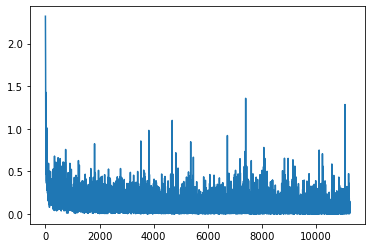

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2) # полносвязная модель
criterion = nn.NLLLoss()
train_nn(model, train, optimizer, criterion, 15)

In [38]:
print(accuracy(model, val))

0.9753


In [107]:
conv_model = CNN() # сверточная модель
optimizer = torch.optim.Adam(conv_model.parameters(), lr=1e-2)
criterion = nn.NLLLoss()
train_nn(conv_model, train, optimizer, criterion, 20, lin=False)

0.9716 0.9731
0.9754666666666667 0.9745
0.9790166666666666 0.9784
0.9816 0.9794
0.9782 0.978
0.9818333333333333 0.9789
0.9800333333333333 0.9777
0.9730333333333333 0.9686
0.9842 0.9836
0.9743333333333334 0.9705
0.9812166666666666 0.9793
0.9780666666666666 0.9759
0.9821166666666666 0.9812
0.98495 0.9823
0.9848666666666667 0.9809
0.9812333333333333 0.9774
0.9824833333333334 0.982
0.9772166666666666 0.9744
0.9835166666666667 0.9797
0.9828 0.981


KeyboardInterrupt: 

### Регуляризация

Вы можете заметить, что с какого-то момента функция потерь на `val` перестаёт падать (а потом и начинает расти), при этом лосс на `train` стабильно убывает. Это связано с переобучением. Если сеть достаточно большая, то нейроны смогут адаптироваться для получения меньшего лосса на отдельном примере, что не очень хорошо обобщается под данные, которые модель ещё не видела. Например сеть может выучить правило «если этот пиксель имеет такое-то значение, то это шестёрка», в структуре сети это будет выражаться очень сильной связью между нейронами. Для этого в нейросетях используют методы регуляризации на веса сети или на процесс обучения.

Самый популярный из них на данный момент — Dropout (в PyTorch — `nn.Dropout`). Это отдельный слой, который во время обучения с вероятностью $p$ независимо по всем элементам зануляет их значения. Это мешает нейронам адаптироваться.

<img width='600px' src='https://cdn-images-1.medium.com/max/1200/1*iWQzxhVlvadk6VAJjsgXgg.png'>

## Автоэнкодеры

**Автоэнкодеры** — это сети, которые учатся восстанавливать свои же входные данные. Такой тип обучения иногда называют self-supervised.


<img width='400px' src='https://habrastorage.org/web/cf6/228/613/cf6228613fdc4f8fb819cbd41bb677eb.png'>

Казалось бы, выучить функцию $f(x) = x$ очень легко, но в автоэнкодеры устроены так, что внутри них вся информация в какой-то момент проходит через скрытый слой небольшой размерности, и поэтому автоэнкодеры просто не имеют возможности идеально точно скопировать свой вход на выходе.

Поэтому сети приходится выучивать в этом крытом очень сжатое и информативное представление данных, что потом можно будет использовать для разных интересных вещей.

Например, для визуализации: можно сделать скрытый слой размера 2 и вывести данные на плоскость.

<img width='800px' src='https://i.stack.imgur.com/2gSs1.png'>

Повсеместно используемый PCA на самом деле является частным случаем автоэнкодера: из преобразований разрешается использовать только линейные.

Мы также можем использовать скрытые состояния для морфинга — плавного перехода между объектами.

<img width='250px' src='https://camo.githubusercontent.com/fa61cfca07320919eb6430a2a06f98d3e68e29c1/68747470733a2f2f692e696d6775722e636f6d2f4f72554a7339562e676966'>

Обозначим уже обученный на данных энкодер как функцию $e$, а декодер как функцию $g$. Тогда морфинг между изображениями $A$ и $B$ мы можем сделать так: переведем изображения A и B в скрытые состояния $a = e(A)$ и $b = e(B)$, а затем каждый кадр генерируется как

$$ C = d((1-t) \cdot a + t \cdot b) $$

где $t$ равномерно изменяется от 0 до 1. Иными словами, мы берём все точки на отрезке ab и последовательно декодируем.

Это вам и предстоит реализовать.

In [48]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, latent_dim),
            nn.ReLU()
        )
        
        self.decode = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decode(self.encode(x))

In [58]:
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_space):
        super().__init__()
        self.enc_conv = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3), padding=1),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (3, 3), padding=1),
            nn.MaxPool2d((2, 2), stride=(2, 2))
        )
        
        self.enc_linear = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_space),
            nn.ReLU()
        )
        
        self.dec_linear = nn.Sequential(
            nn.Linear(latent_space, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64 * 7 * 7),
            nn.ReLU()
        )
        
        self.dec_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 1, (3, 3), padding=1),
            nn.Upsample(scale_factor=2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.decode(self.encode(x))
        
    def encode(self, x):
        x = self.enc_conv(x)
        x = x.view(-1, 64 * 7 * 7)
        return self.enc_linear(x)
    
    def decode(self, x):
        x = self.dec_linear(x)
        x = x.view(-1, 64, 7, 7)
        return self.dec_conv(x)
        

In [56]:
def train_AE(model, train, optimizer, criterion, n_epochs, lin=True):
    for epoch in range(n_epochs):
        train_loss = 0
        for data, _ in train:
            if lin:
                data = data.view(-1, 784)
            optimizer.zero_grad()
            reconstructed = model(data)
            loss = criterion(data, reconstructed)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print('epoch %d, loss %.4f' % (epoch, train_loss / len(train)))

In [ ]:
criterion = torch.nn.MSELoss()
model = Autoencoder(4)
optimizer = torch.optim.Adam(model.parameters())
train_AE(model, train, optimizer, criterion, 10)

In [ ]:
criterion = torch.nn.MSELoss()
conv_model = ConvAutoencoder(4)
optimizer = torch.optim.Adam(conv_model.parameters())
train_AE(conv_model, train, optimizer, criterion, 15, lin=False)

In [63]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import numpy

Теперь попытаемся сделать гифку, как выше.

Анимации `matplotlib` — это жесть, не надо особо пытаться разобраться в коде снизу. Возможно, вам придётся пройти квест и поставить `ffmpeg` (`apt instal ffmpeg`, `pip install ffmpeg` и перезапуска тетрадки должно хватить в большинстве случаев).

In [67]:
def get(x, lin=True):
    if lin:
        return train.dataset[x][0].view(1, 784)
    return train.dataset[x][0].view(1, 1, 28, 28)

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay, model, lin=True): # доп. аргумент - модель
    # перегоняем в латентное пространство все картинки на входе
    latent = [model.encode(get(k, lin)).data for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in numpy.linspace(0, 1, steps):
            # получаем проинтерполированную точку
            c = a*(1-t)+b*t
            # ...и декодируем её в изображение
            morphed = model.decode(c).data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

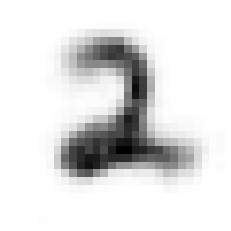

In [217]:
morph(numpy.random.randint(0, len(train.dataset), 30), 20, 60, conv_model, False) #сверточный автоэнкодер

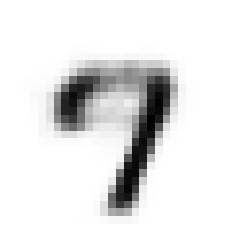

In [68]:
morph(numpy.random.randint(0, len(train.dataset), 30), 20, 60, model) # автоэнкодер с линейными слоямми

# Визуализация

In [51]:
criterion = torch.nn.MSELoss()
model_vis = Autoencoder(2)
optimizer = torch.optim.Adam(model_vis.parameters())
train_AE(model_vis, train, optimizer, criterion, 13)

epoch 0, loss 0.0596
epoch 1, loss 0.0471
epoch 2, loss 0.0441
epoch 3, loss 0.0426
epoch 4, loss 0.0414
epoch 5, loss 0.0405
epoch 6, loss 0.0399
epoch 7, loss 0.0395
epoch 8, loss 0.0390
epoch 9, loss 0.0386
epoch 10, loss 0.0383
epoch 11, loss 0.0380
epoch 12, loss 0.0379


In [52]:
dct = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
for a in train:
    res = model_vis.encode(a[0].view(-1, 784))
    for i, latent in enumerate(res):
        dct[a[1][i].item()].append((latent[0].item(), latent[1].item()))


Text(0.5, 1.0, 'Autiencoder')

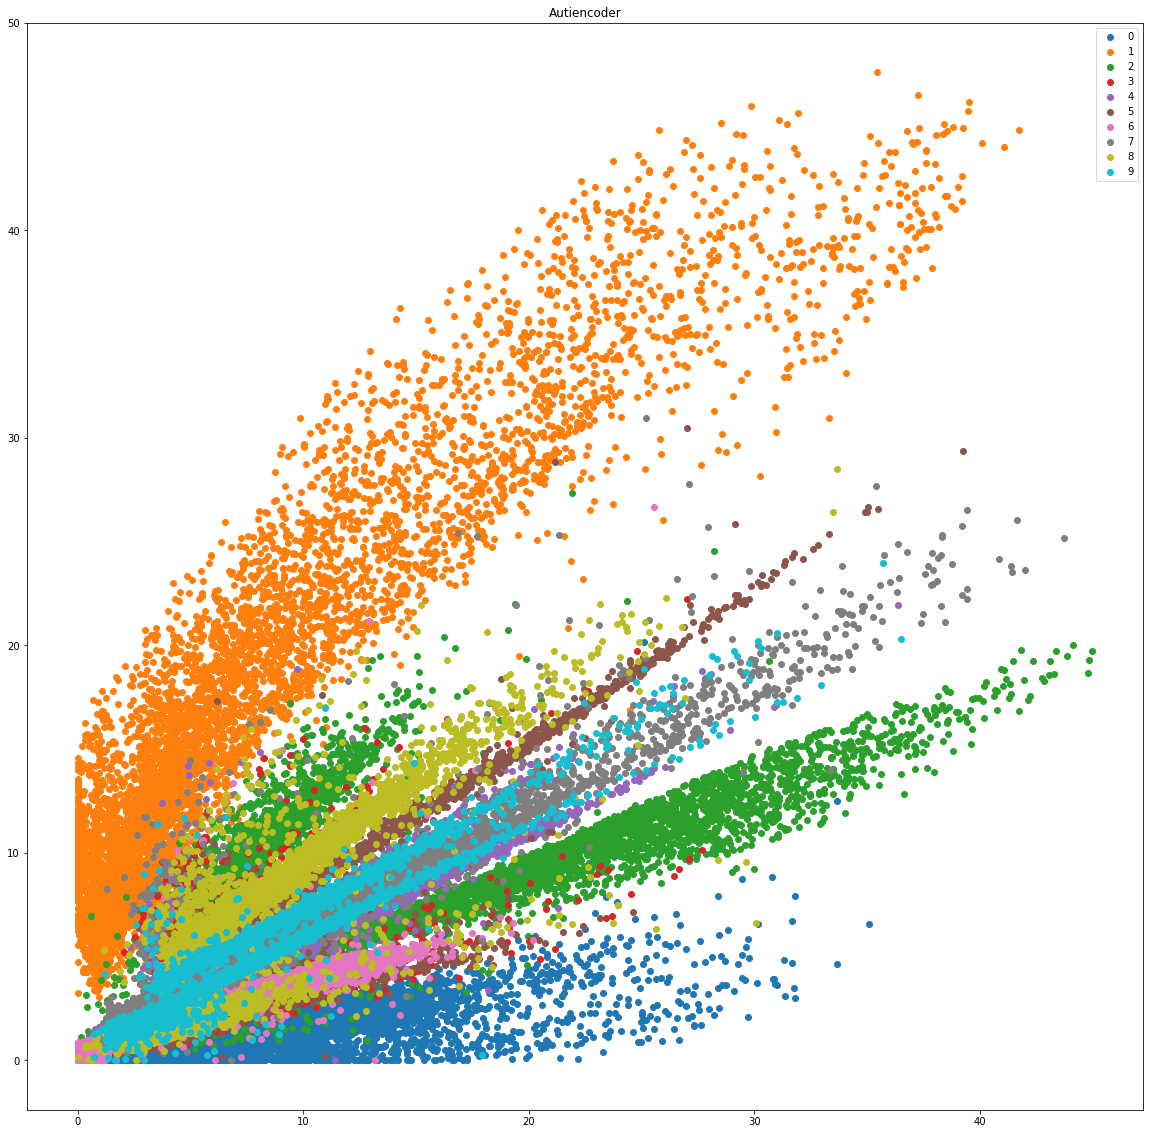

In [69]:
import matplotlib.pyplot as plt


plt.figure(figsize=(20, 20))
for i in range(10):
    plt.scatter([x[0] for x in dct[i]], [x[1] for x in dct[i]], label=i)

plt.legend()
plt.title('Autiencoder')

# Домашнее задание

* Получить точность 97.5% на валидации MNIST.
* Реализовать морфинг автоэнкодером (без формальных критериев — просто получите красивую гифку).
* Визуализировать MNIST автоэнкодером (обучить автоэнкодер с латентным пространством размерности 2 и вывести через scatter точки разного цвета).

### *Свёртки

Если у вас останется время, вы можете улучшить результаты, используя свёртки.

О свёрточных сетях в деталях вы узнаете на следующем занятии, а пока что вы можете использовать `nn.Conv2d`, `nn.MaxPool2d`, и `nn.ConvTranspose2d` просто как более продвинутые слои для классификатора и автоэнкодера, даже не особо понимая, как они внутри работают.

Основная задача «нейроинженеров» — придумать, как выглядело бы решение этой задачи на уровне программы с неизвестными параметрами, и подбирать соответствующие архитектуры. [Эксперименты с дропаутом](https://arxiv.org/pdf/1701.05369.pdf) показывают, что в Linear примерно 99% весов на самом деле можно выкинуть. Логично, что в оптимальной архитектуре не должно быть бесполезных весов — лишние параметры всегда ведут к переобучению. В случае с картинками решение в том, чтобы использовать информацию о расположении пикселей относительно друг друга, чтобы создать слой, который смотрит на более релевантные фичи. Мотивация заключается примерно в этом, подробнее — через неделю.

<img width='250px' src='https://cdn-images-1.medium.com/max/1600/0*iqNdZWyNeCr5tCkc.'>